# Presentation
For generating any figures to be used in presentations

## Stochastic Gradient Descent and Newtonian

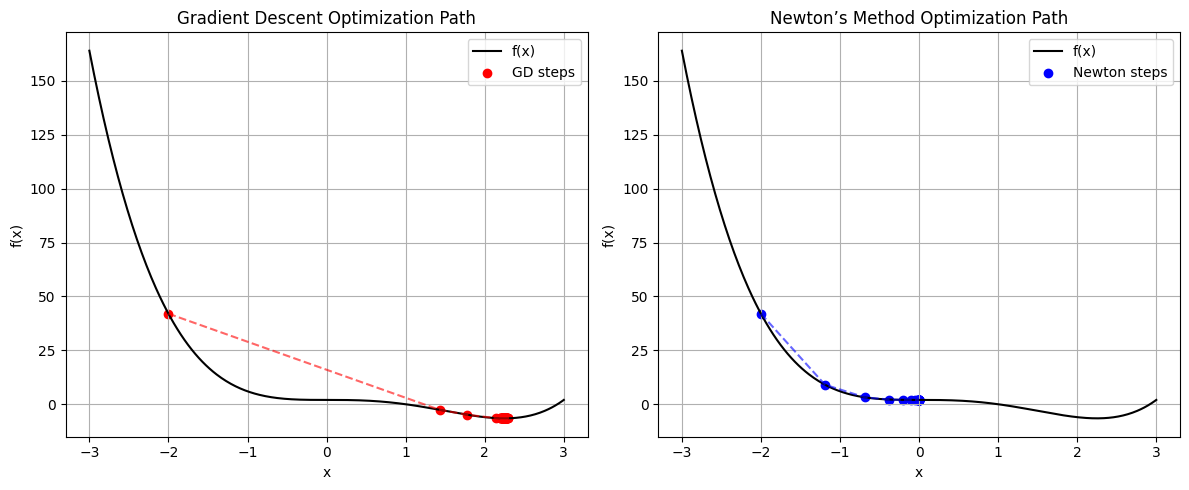

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Define the objective function and its derivatives
def f(x):
    return x**4 - 3*x**3 + 2

def f_prime(x):
    return 4*x**3 - 9*x**2

def f_double_prime(x):
    return 12*x**2 - 18*x

# Gradient Descent implementation
def stochastic_gradient_descent(start_x, learning_rate, iterations, noise_scale=0.5):
    x = start_x
    path = [x]
    for _ in range(iterations):
        grad = f_prime(x)
        # Add noise to simulate stochasticity
        noisy_grad = grad + np.random.normal(0, noise_scale)
        x = x - learning_rate * noisy_grad
        path.append(x)
    return np.array(path)

# Newton’s Method implementation
def newton_method(start_x, iterations):
    x = start_x
    path = [x]
    for _ in range(iterations):
        grad = f_prime(x)
        hess = f_double_prime(x)
        if hess == 0:
            break
        x = x - grad / hess
        path.append(x)
    return np.array(path)

# Parameters
start_x = -2.0   # start near the right side
iterations = 50
learning_rate = 0.05

# Run both methods
gd_path = stochastic_gradient_descent(start_x, learning_rate, iterations)
newton_path = newton_method(start_x, iterations)

# Generate curve data for plotting
x_vals = np.linspace(-3, 3, 400)
y_vals = f(x_vals)

# Plot Gradient Descent path
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x_vals, y_vals, 'k-', label='f(x)')
plt.scatter(gd_path, f(gd_path), color='red', label='GD steps')
plt.plot(gd_path, f(gd_path), 'r--', alpha=0.6)
plt.title('Gradient Descent Optimization Path')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

# Plot Newton’s Method path
plt.subplot(1, 2, 2)
plt.plot(x_vals, y_vals, 'k-', label='f(x)')
plt.scatter(newton_path, f(newton_path), color='blue', label='Newton steps')
plt.plot(newton_path, f(newton_path), 'b--', alpha=0.6)
plt.title('Newton’s Method Optimization Path')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

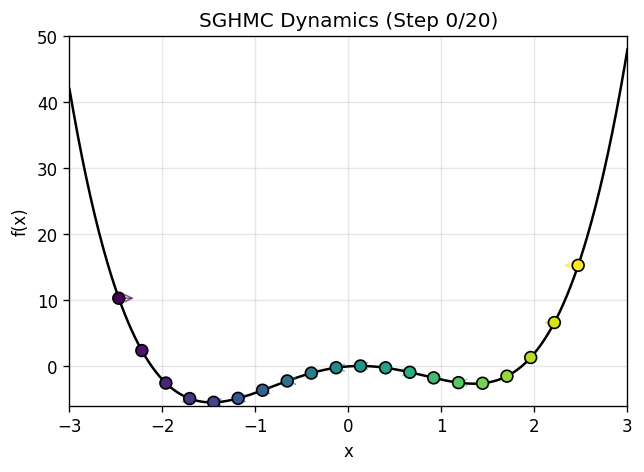

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import math
import os

# --------------------------------------
# Objective function and its derivatives
# --------------------------------------
def f(x):
    """Objective: a double-well potential with a local and global minimum"""
    return x**4 - 4*x**2 + x

def grad_f(x):
    """Gradient of the objective"""
    return 4*x**3 - 8*x + 1

# --------------------------------------
# SGHMC-like dynamics (1D version)
# --------------------------------------
def sghmc_step(x, p, eps, gamma, mass):
    """
    One step of a simple SGHMC-like integrator (discretized underdamped Langevin):
      p <- p - eps * grad(x) - gamma * p + sqrt(2 * gamma * eps) * N(0, sqrt(mass))
      x <- x + eps * p / mass
    """
    noise_std = math.sqrt(2 * gamma * eps * mass)
    p = p - eps * grad_f(x) - gamma * p + noise_std * np.random.randn(*p.shape)
    x = x + eps * p / mass
    return x, p

# --------------------------------------
# Simulation parameters
# --------------------------------------
n_particles = 20       # number of particles
steps = 20           # total iterations
eps = 0.05            # integration step size
gamma = 0.1           # friction/damping coefficient
mass = 4.0
record_every = 2      # how often to record a frame
np.random.seed(42)

# initialize positions and momenta
init_positions = np.linspace(-2.5, 2.5, n_particles)
x = init_positions.copy().astype(float)
p = 0.2 * np.random.randn(n_particles)

# plotting data
x_plot = np.linspace(-3.0, 3.0, 800)
y_plot = f(x_plot)

# --------------------------------------
# Generate frames for the GIF
# --------------------------------------
frames = []
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)
colors = plt.cm.viridis(np.linspace(0, 1, n_particles))

for t in range(steps):
    # take one SGHMC step
    x, p = sghmc_step(x, p, eps, gamma, mass)
    
    if t % record_every == 0:
        ax.clear()
        ax.plot(x_plot, y_plot, 'k-', linewidth=1.5)
        ax.set_xlim(-3, 3)
        ax.set_ylim(np.min(y_plot) - 0.5, np.max(y_plot) + 2.0)
        ax.set_title(f"SGHMC Dynamics (Step {t}/{steps})")
        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")
        ax.grid(alpha=0.3)
        
        # plot particles
        ax.scatter(x, f(x), s=50, c=colors, edgecolor='k', zorder=5)
        
        # momentum arrows
        for i in range(n_particles):
            dx = 0.08 * p[i]
            ax.annotate('', xy=(x[i] + dx, f(x[i])),
                        xytext=(x[i], f(x[i])),
                        arrowprops=dict(arrowstyle='->', lw=1.0, alpha=0.6, color=colors[i]))
        
        # ax.text(0.02, 0.98, f"eps={eps}, gamma={gamma}, mass={mass}", transform=ax.transAxes,
        #        va='top', ha='left', fontsize=9, bbox=dict(boxstyle="round", fc="w", alpha=0.6))
        
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_argb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        frames.append(image)

plt.close(fig)

# --------------------------------------
# Save animation as GIF
# --------------------------------------
out_path = "sghmc.gif"
imageio.mimsave(out_path, frames, fps=20)
print(f"Saved SGHMC visualization to: {os.path.abspath(out_path)}")